In [12]:
import pandas as pd

news = pd.read_csv('D:/Project-Fake_news_classifier/WELFake_Dataset.csv')

In [13]:
news

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


([<matplotlib.patches.Wedge at 0x25d0f7595e0>,
 [Text(-1.0988739955513318, 0.04975883741660046, 'Fake_News'),
  Text(1.0988739955513318, -0.0497588374166006, 'Real_News')],
 [Text(-0.5993858157552718, 0.02714118404541843, '48.6%'),
  Text(0.5993858157552718, -0.027141184045418508, '51.4%')])

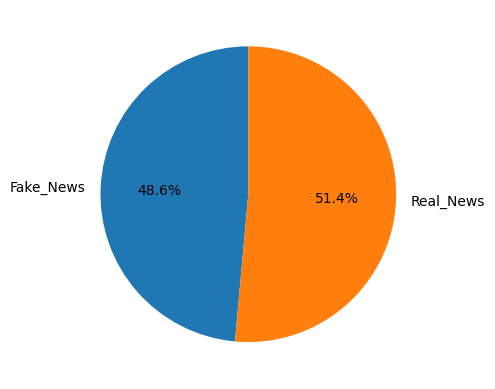

In [14]:
import matplotlib.pyplot as plt
labels = news['label'].value_counts()
plt.pie([labels[0],labels[1]],labels=['Fake_News','Real_News'],autopct='%1.1f%%',startangle=90)


In [15]:
# Data Cleaning

# Dropping the unnamed column
news = news.drop(columns=['Unnamed: 0'],axis=1)

#Dropping the Duplicates
news = news.dropna()

#Checking the duplicates
print(f'The Number of Duplicates are: {news.duplicated().sum()}')

# #Dropping the Duplicates
news = news.drop_duplicates()

#reseting the index:
news = news.reset_index(drop=True)

news[['title','text']] = news[['title','text']].apply(lambda col: col.str.lower())

The Number of Duplicates are: 8416


In [16]:
import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords


lemmatizer = WordNetLemmatizer()
stemmatizer = PorterStemmer()

def text_preprocessor(text):

    # Removing the punctuations
    text = re.sub(r'[^a-z0-9\s]',"",text)

    #tokenize
    tokens = nltk.word_tokenize(text)

    #removing the stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    #stemming
    # stemmed_tokens  = [stemmatizer.stem(token) for token in filtered_tokens]

    #lemmatizing
    lemmatized_texts = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(lemmatized_texts)

news['title'] = news['title'].apply(text_preprocessor)
news['text'] = news['text'].apply(text_preprocessor)

In [32]:
combined_text = news['title'].astype(str)+" "+news['text'].astype(str)
unique_words  = set()
for text in combined_text:
    words = text.lower().split()
    unique_words.update(words)

vocab_size = len(unique_words)+1
print(vocab_size)

342850


In [18]:
from tensorflow.keras.preprocessing.text import one_hot

one_hot_title = [one_hot(title,vocab_size)for title in news['title']]
one_hot_text = [one_hot(text,vocab_size) for text in news['text']]

In [19]:
max_length = 100

In [20]:
from tensorflow.keras.utils import pad_sequences
title_padded = pad_sequences(one_hot_title,maxlen=max_length,padding='pre')
text_padded = pad_sequences(one_hot_text,maxlen=max_length,padding='pre')

In [21]:
import numpy as np

# Concatenate titles and texts if necessary
X_combined = np.concatenate((title_padded, text_padded), axis=1)  # Adjust axis depending on your needs


In [22]:
from sklearn.model_selection import train_test_split


# Replace `labels` with your actual labels for the dataset
labels = news['label'].values  # Use the actual column for labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

def build_model(hyper):

    # Assuming vocab_size and max_length are defined
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100))  # Adjust input_length if needed
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


In [58]:
import keras_tuner as kt
from sklearn.metrics import classification_report

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Targeting validation accuracy for the tuning
    max_trials=10,  # Number of hyperparameter sets to try
    executions_per_trial=2,  # Number of times to execute each trial (to reduce variance)
    directory='my_dir',  # Where to save the results
    project_name='lstm_hyperparameter_tuning'
)

# Perform the search
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)

# Get the best model after hyperparameter tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions and generate a classification report
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Trial 1 Complete [02h 01m 20s]
val_accuracy: 0.9351485371589661

Best val_accuracy So Far: 0.9351485371589661
Total elapsed time: 02h 01m 20s


d:\Project-Fake_news_classifier\news_env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    34,285,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,445,901 (131.40 MB)

 Trainable params: 34,445,901 (131.40 MB)

 Non-trainable params: 0 (0.00 B)

395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9363 - loss: 0.1988
Test Accuracy: 0.9340198040008545
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6955
           1       0.94      0.92      0.93      5670

    accuracy                           0.93     12625
   macro avg       0.93      0.93      0.93     12625
weighted avg       0.93      0.93      0.93     12625



In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



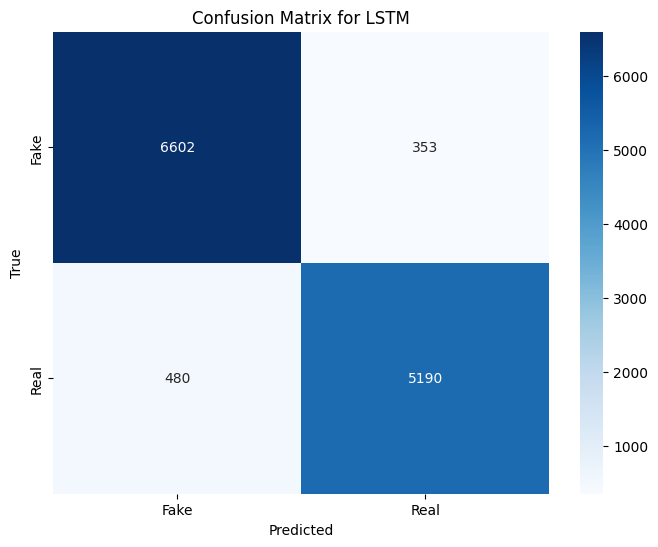

In [61]:
cm_lstm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm_lstm,"LSTM")

In [53]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Sample data - replace with your actual data
# Assuming news['text'] is your input text and news['label'] is your binary label (0 for fake, 1 for real)
X = combined_text.values
y = news['label'].values

# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 10000  # Set the number of words to consider

# Building the Bidirectional LSTM Model
embedding_dim = 128  # Dimension of the embedding layer

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Bidirectional(LSTM(32)))  # Another Bidirectional LSTM layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Summary
model.summary()

# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Evaluating the Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Thresholding at 0.5

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - accuracy: 0.8534 - loss: 0.3202 - val_accuracy: 0.9394 - val_loss: 0.1655
Epoch 2/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 141s 223ms/step - accuracy: 0.9639 - loss: 0.1045 - val_accuracy: 0.9347 - val_loss: 0.1733
Epoch 3/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 148s 234ms/step - accuracy: 0.9819 - loss: 0.0568 - val_accuracy: 0.9303 - val_loss: 0.1895
Epoch 4/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 148s 234ms/step - accuracy: 0.9881 - loss: 0.0374 - val_accuracy: 0.9328 - val_loss: 0.2543
Epoch 5/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 144s 228ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9332 - val_loss: 0.2721
Epoch 6/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - accuracy: 0.9954 - loss: 0.0138 - val_accuracy: 0.9278 - val_loss: 0.3118
Epoch 7/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 144s 228ms/step - accuracy: 0.9966 - loss: 0.0105 - val_accuracy: 0.9294 - val_loss: 0.3559
Epoch 8/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 143s 226ms/step - accuracy: 0.9976 -

In [ ]:
# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluating the Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Thresholding at 0.5

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Concatenate 'title' and 'text' columns into a new column in the news DataFrame
news['combined'] = news['title'] + " " + news['text']

# Step 1: Apply TF-IDF Vectorizer on the combined column
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(news['combined'])  # Use combined column for text

# Labels (assuming 'label' is already in the news dataframe)
y = news['label']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# For XGBoost, convert to dense matrix
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

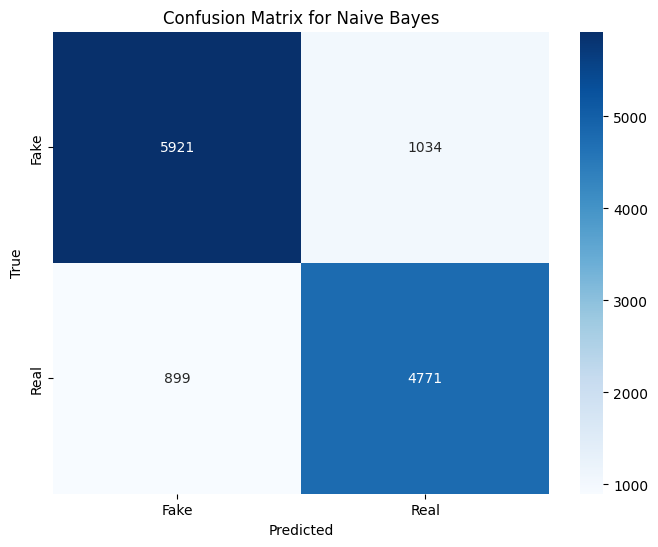

In [43]:
#Training the Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

#Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(cm_nb, "Naive Bayes")

In [44]:
# Naive Bayes Evaluation
print("---- Naive Bayes ----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

---- Naive Bayes ----
Accuracy: 0.8468910891089109
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6955
           1       0.82      0.84      0.83      5670

    accuracy                           0.85     12625
   macro avg       0.85      0.85      0.85     12625
weighted avg       0.85      0.85      0.85     12625



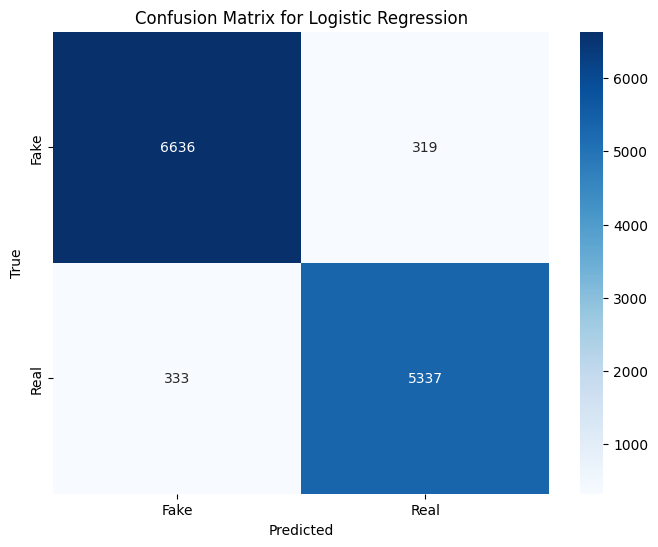

In [45]:
#Training the LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

#Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm_lr, "Logistic Regression")

In [46]:
# Logistic Regression Evaluation
print("\n---- Logistic Regression ----")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


---- Logistic Regression ----
Accuracy: 0.9483564356435643
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6955
           1       0.94      0.94      0.94      5670

    accuracy                           0.95     12625
   macro avg       0.95      0.95      0.95     12625
weighted avg       0.95      0.95      0.95     12625

